In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import time
import os
import argparse
import matplotlib.pyplot as plt
from tqdm import tqdm
from Pretrain_DeepVAE import *


In [2]:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'


# GT0_tensor = torch.tensor(np.load('Data/GT/GT0.npy')).float().to(device)
GT1_tensor = torch.tensor(np.load('Data/GT/GT1.npy')).float().to(device)
GT2_tensor = torch.tensor(np.load('Data/GT/GT2.npy')).float().to(device)
GT3_tensor = torch.tensor(np.load('Data/GT/GT3.npy')).float().to(device)
GT4_tensor = torch.tensor(np.load('Data/GT/GT4.npy')).float().to(device)
GT5_tensor = torch.tensor(np.load('Data/GT/GT5.npy')).float().to(device)

'''500*5 data'''
GT_train = torch.cat((GT1_tensor[0:500]
                        , GT2_tensor[0:500]
                        , GT3_tensor[0:500]
                        , GT4_tensor[0:500]
                        , GT5_tensor[0:500]
                        ), dim=0)
GT_val = torch.cat((GT1_tensor[-1500:-500]
                    , GT2_tensor[-1500:-500]
                    , GT3_tensor[-1500:-500]
                    , GT4_tensor[-1500:-500]
                    , GT5_tensor[-1500:-500]
                    ), dim=0)
GT_test = torch.cat((GT1_tensor[-500:]
                    , GT2_tensor[-500:]
                    , GT3_tensor[-500:]
                    , GT4_tensor[-500:]
                    , GT5_tensor[-500:]
                    ), dim=0)

# # 创建一个索引数组，并随机打乱
# indices = np.arange(len(V_train))
# np.random.shuffle(indices)

# 使用打乱的索引重新排列数据集
# GT_train = GT_train[indices]
print(GT_test.shape)

torch.Size([2500, 1, 48, 48])


In [5]:
model = DeepVAE().to(device)

criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=1.5e-4 * 128 / 256, 
                              betas=(0.9, 0.95), weight_decay=0.05)
model.load_state_dict(torch.load('Model/GT_pretrain/GT_DeepVAE.pth'), strict=False)
model.eval()  # 将模型设置为评估模式
batch_size = 128
num_batches = (len(GT_test) + batch_size - 1) // batch_size
test_loss = 0.0
all_outputs = []  # 用于存储每个批次的输出
with torch.no_grad():  # 不需要计算梯度，节省内存和计算资源
    for i in range(num_batches):
        start = i * batch_size
        end = min(start + batch_size, len(GT_test))
        
        # 获取当前批次的输入和真实值（ground truth）
        batch_inputs = GT_test[start:end].to(device)
        batch_targets = GT_test[start:end].to(device)
        
        # 前向传播
        test_outputs = model(batch_inputs)
        
        # 计算损失
        loss = criterion(test_outputs, batch_targets)
        
        # 累加损失
        test_loss += loss.item()
        
        # 存储当前批次的输出
        all_outputs.append(test_outputs.cpu())  # 将输出移动到 CPU 并存储

# 计算平均损失
test_loss /= num_batches
print(f'Test Loss: {test_loss:.10f}')

all_outputs = torch.cat(all_outputs, dim=0)  # 在第0维上拼接


Test Loss: 0.0000006263


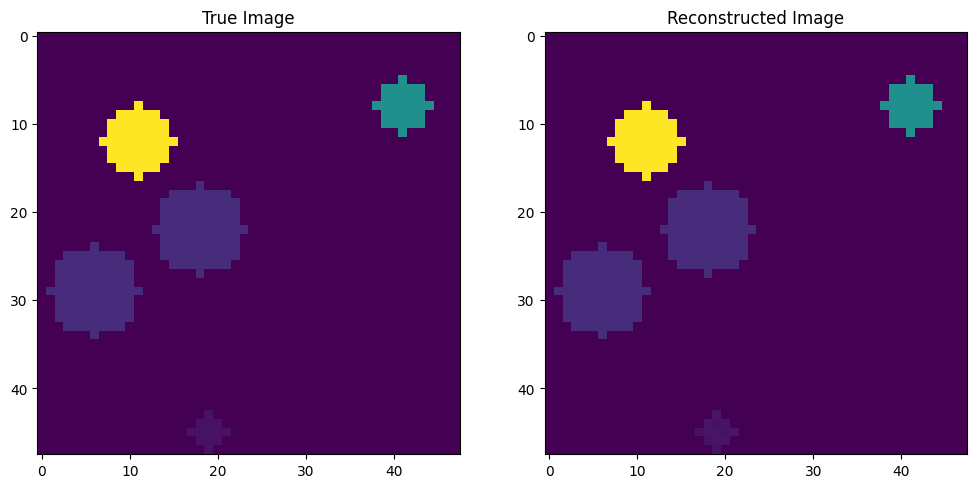

<Figure size 640x480 with 0 Axes>

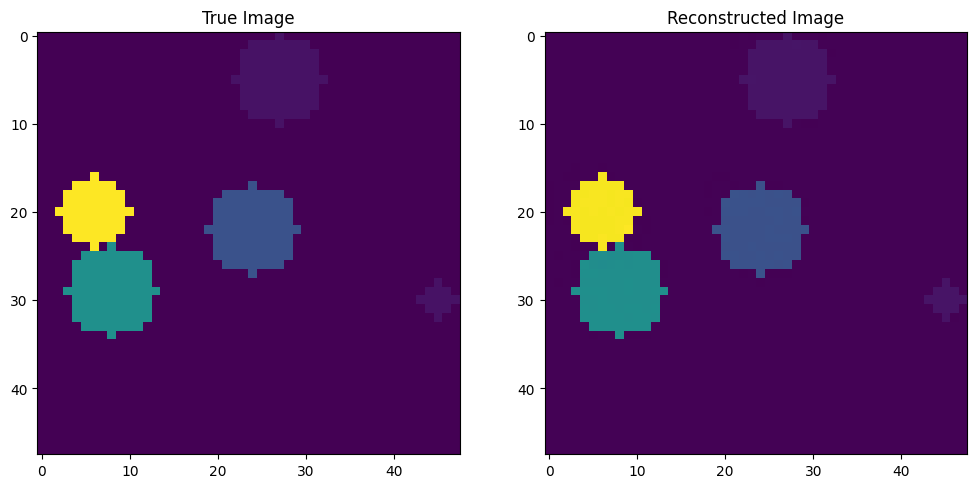

<Figure size 640x480 with 0 Axes>

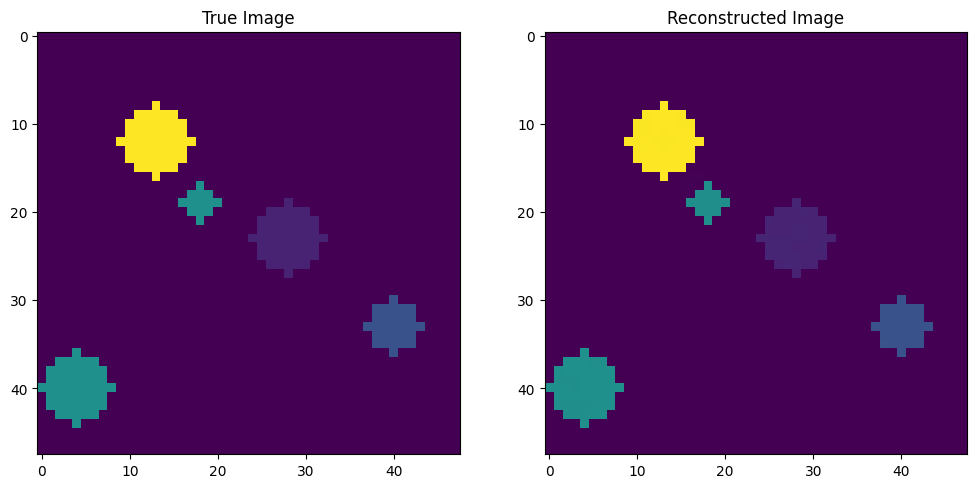

<Figure size 640x480 with 0 Axes>

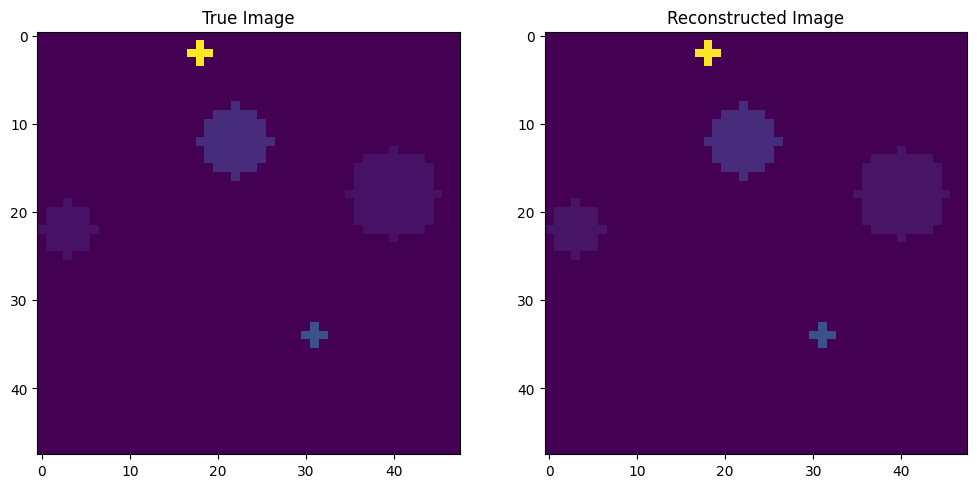

<Figure size 640x480 with 0 Axes>

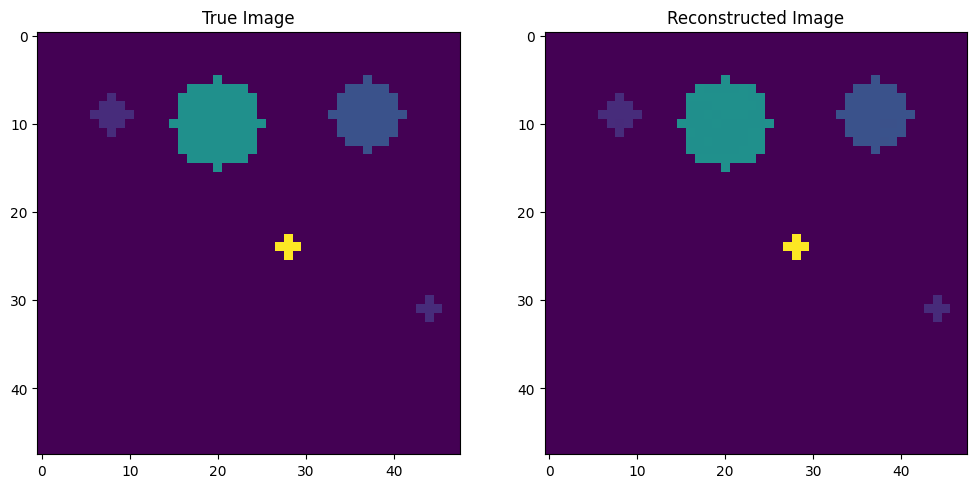

<Figure size 640x480 with 0 Axes>

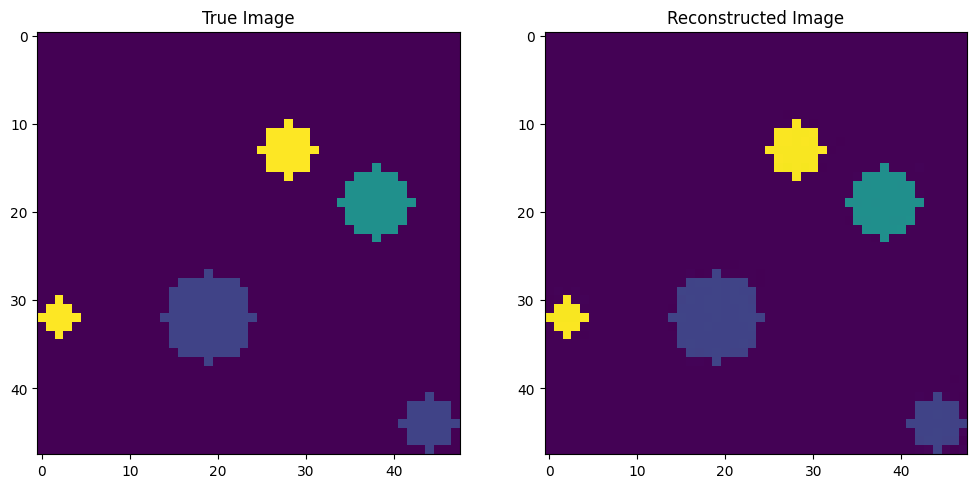

<Figure size 640x480 with 0 Axes>

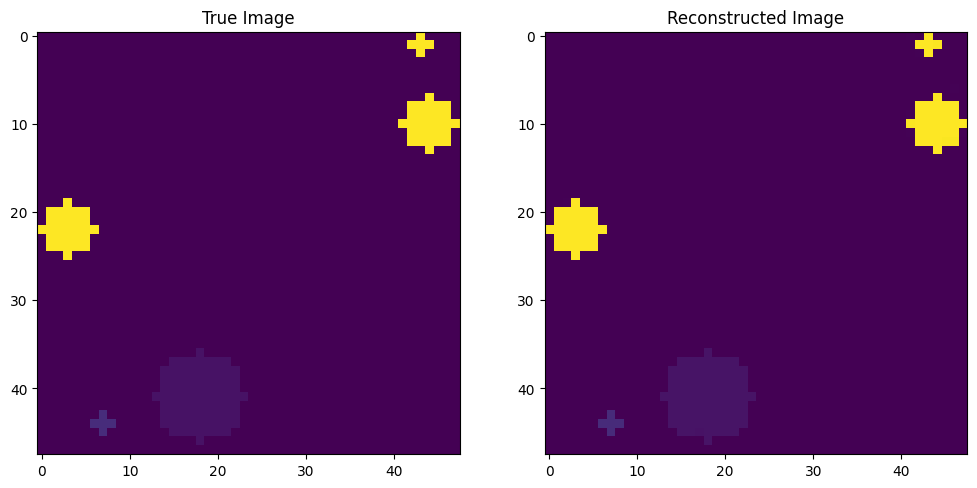

<Figure size 640x480 with 0 Axes>

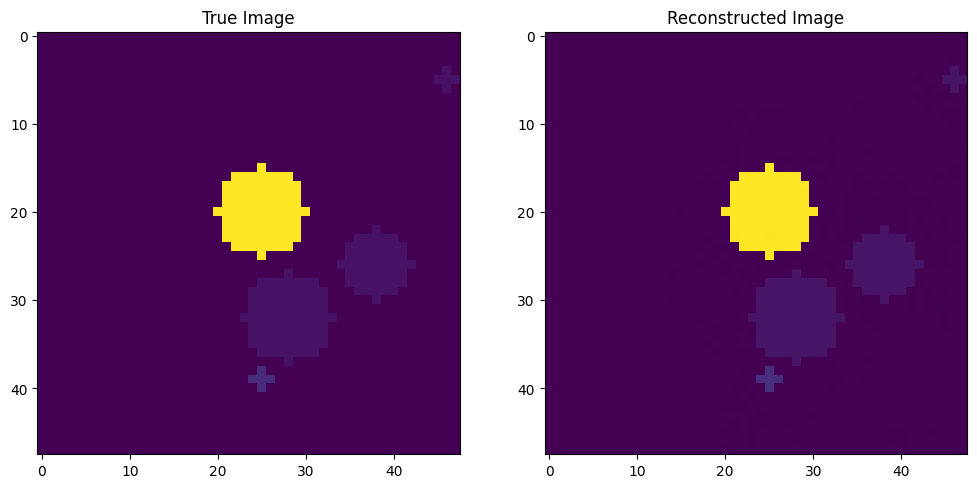

<Figure size 640x480 with 0 Axes>

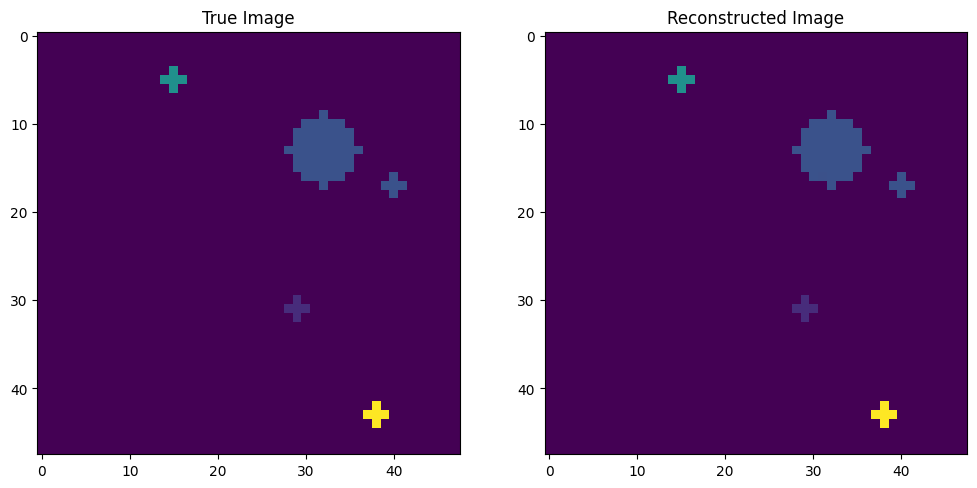

<Figure size 640x480 with 0 Axes>

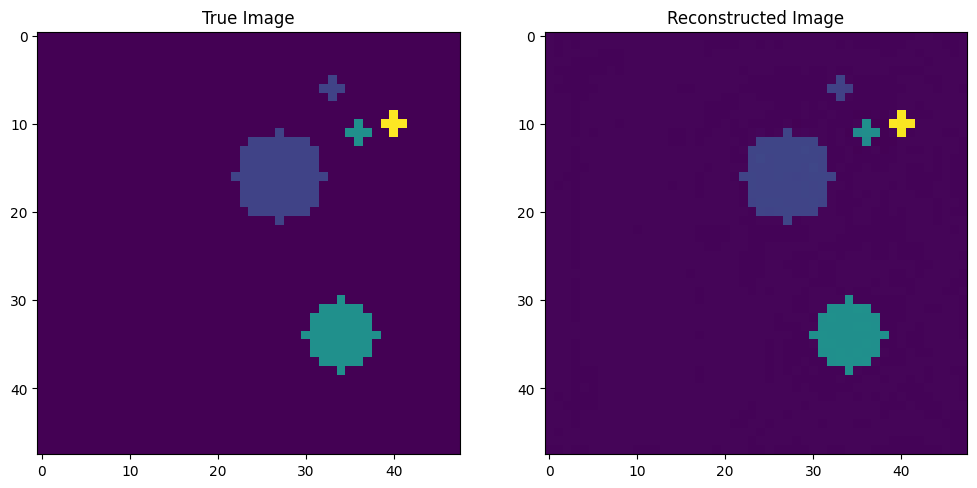

<Figure size 640x480 with 0 Axes>

In [6]:
from matplotlib.colors import Normalize
# 将张量转换为NumPy数组并展平
Pre_numpy = all_outputs.cpu().detach().numpy().reshape(2500, -1)
Label_numpy = GT_test.cpu().detach().numpy().reshape(2500, -1)
# 保存到txt文件
# np.savetxt('Result/Pre_FCNN_square.txt', Pre_numpy, fmt='%f')
# np.savetxt('Result/Label_FCNN_square.txt', Label_numpy, fmt='%f')
# 随机选择测试数据并预测
# N = np.random.randint(0, 2490)
N = 2000
for idx in range(N,N+10):
    Prediction = all_outputs[idx]  # 添加批处理维度
    Label_test = GT_test[idx].squeeze()
    Label_test.shape

    # 绘制真实图像和重构图像
    plt.figure(figsize=(12,12))
    plt.subplot(1, 2, 1)
    plt.imshow(Label_test, norm=Normalize())
    plt.title('True Image')
    # plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(Prediction.cpu().detach().squeeze().numpy(), norm=Normalize())
    plt.title('Reconstructed Image')
    # plt.colorbar()
    plt.show()


    # 添加一个短暂的暂停时间，以便每帧之间有足够的时间显示
    time.sleep(0.1)

    # 清除当前的绘图，避免重叠
    plt.clf()